
# **Quantum Error Correction with the 3-Qubit Repetition Code**

### **1. Introduction**

In this experiment, I implemented the "Hello World" of Quantum Error Correction (QEC): the **3-Qubit Bit Flip Code**.
One of the biggest challenges in quantum computing is noise. Unlike classical bits, which are stable, qubits are fragile and prone to errors. A simple "flip" (essentially an unplanned $X$ gate) can turn a $∣0⟩$ into a $∣1⟩$, destroying the validity of a calculation.

To combat this, I used the principle of **redundancy**. Instead of storing my logical information in a single physical qubit, I "encoded" it across three entangled qubits.

### **2. The Encoding Protocol**

My goal was to protect a logical zero state $∣0⟩_L$.
Instead of just preparing one qubit in state $∣0⟩$, I used CNOT gates to spread this state across three physical qubits, creating the entangled state:
$$∣0⟩_L → ∣000⟩$$ $$∣1⟩_L → ∣111⟩$$


This is known as the "Code Space." Any state that deviates from these triplets (like $∣100⟩$ or $∣010⟩$) immediately signals that an error has occurred.

### **3. Syndrome Measurement (The Diagnosis)**

A critical rule in quantum mechanics is that I cannot simply measure the data qubits to check for errors. Doing so would collapse any superposition and destroy the quantum information I am trying to protect.

Instead, I performed **Syndrome Measurements** using two additional "ancilla" (helper) qubits. I measured the **parity** of neighboring qubits rather than their specific values:

* **Syndrome A:** Checks if Qubit 0 and Qubit 1 have the same value ($Z_0Z_1$).
* **Syndrome B:** Checks if Qubit 1 and Qubit 2 have the same value ($Z_1Z_2$).

This allows me to diagnose the error without peeking at the data:

* If **Syndrome A** fails (parity mismatch), I know Qubit 0 flipped.
* If **Syndrome B** fails, I know Qubit 2 flipped.
* If **Both** fail, I know the middle Qubit 1 flipped.

### **4. Real-Time Correction**

Using Qiskit's dynamic circuits (`if_test`), I implemented a real-time correction loop. Based on the measurement results of the ancilla qubits, I applied a corrective $X$ gate to the specific qubit identified by the syndrome. This effectively flips the qubit back to its correct state before the final readout.

### **5. Results: Logical vs. Physical Error**

My simulation results demonstrate the fundamental advantage of QEC. I swept the physical error rate $p$ (the probability of a single wire failing) from 0.0 to 0.5.

* **Physical Error (Red Line):** This is the baseline failure rate if I used no correction.
* **Logical Error (Blue Line):** This is the failure rate of my encoded system.

The plot shows a quadratic improvement. For the system to fail, **two or more** qubits must flip simultaneously (e.g., $∣110⟩$), effectively "fooling" the majority vote. The probability of two specific qubits flipping is $p^2$. As long as the physical noise is low (specifically $p<0.5$), my encoded logical qubit is significantly more reliable than the raw physical components.

In [ ]:
pip install qiskit qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error

In [ ]:
def build_repetition_code(error_prob=0.1):
    """
    Constructs the 3-qubit bit flip code with a probabilistic error channel.
    """
    # Registers
    qr_data = QuantumRegister(3, 'data')
    qr_anc = QuantumRegister(2, 'ancilla')
    cr_syn = ClassicalRegister(2, 'syndrome') # To store parity checks
    cr_out = ClassicalRegister(3, 'logical')  # To check final state

    qc = QuantumCircuit(qr_data, qr_anc, cr_syn, cr_out)

    # 1. Encoding (|0> -> |000>)
    # Entangle q0 with q1 and q2
    qc.cx(qr_data[0], qr_data[1])
    qc.cx(qr_data[0], qr_data[2])
    qc.barrier()

    # 2. Error Injection (Simulation Only)
    # We apply a bit flip (X) with probability 'error_prob' to EACH qubit
    # This simulates the environment attacking our memory
    error_gate = pauli_error([('X', error_prob), ('I', 1 - error_prob)])

    # Append error to all 3 data qubits
    for i in range(3):
        qc.append(error_gate, [qr_data[i]])

    qc.barrier()

    # 3. Syndrome Measurement
    # Check Parity of q0-q1 (store in ancilla 0)
    qc.cx(qr_data[0], qr_anc[0])
    qc.cx(qr_data[1], qr_anc[0])

    # Check Parity of q1-q2 (store in ancilla 1)
    qc.cx(qr_data[1], qr_anc[1])
    qc.cx(qr_data[2], qr_anc[1])

    # Measure Syndromes
    qc.measure(qr_anc, cr_syn)
    qc.barrier()

    # 4. Correction (Dynamic Logic)
    # Syndrome is read as decimal integer of bits cr_syn[1], cr_syn[0]
    # Note: Qiskit registers are little-endian in some contexts, be careful.
    # cr_syn[0] is Low bit, cr_syn[1] is High bit.

    # Case 1: Syndrome 01 (decimal 1) -> Error on q2 (Parity 1-2 mismatch only)
    with qc.if_test((cr_syn, 1)):
        qc.x(qr_data[2])

    # Case 2: Syndrome 10 (decimal 2) -> Error on q0 (Parity 0-1 mismatch only)
    with qc.if_test((cr_syn, 2)):
        qc.x(qr_data[0])

    # Case 3: Syndrome 11 (decimal 3) -> Error on q1 (Mismatch on both sides)
    with qc.if_test((cr_syn, 3)):
        qc.x(qr_data[1])

    qc.barrier()

    # 5. Final Readout
    # Measure corrected logical state
    qc.measure(qr_data, cr_out)

    return qc

In [ ]:
def run_qec_simulation():
    print("Running QEC Bit Flip Simulation")

    error_rates = np.linspace(0.0, 0.5, 20)
    logical_errors = []

    # For simulation speed, we skip the NoiseModel object and put errors
    # directly in the circuit using 'pauli_error'.
    backend = AerSimulator()
    shots = 2048

    print(f"Sweeping Physical Error Rate (p) from 0.0 to 0.5...")

    for p in error_rates:
        # Build circuit with specific noise level
        qc = build_repetition_code(error_prob=p)

        # Run
        # We transpile to ensure dynamic circuits (if_test) work on the simulator
        isa_qc = transpile(qc, backend)
        result = backend.run(isa_qc, shots=shots).result()
        counts = result.get_counts()

        # Calculate Logical Error Rate
        # A logical error occurs if the final state is NOT '000'
        # (We encoded '0', so correct output is '000')
        # Note: We consider '111' a failure, even though it's a valid code state,
        # because it means the logical bit flipped from 0 to 1.

        correct_counts = counts.get('000 00', 0) # Format: 'data syndrome'

        # In Qiskit results, keys are 'cr_out cr_syn'. We care about cr_out (left part)
        total_failures = 0
        for key, count in counts.items():
            # Split key: 'logical_bits syndrome_bits'
            measured_data = key.split()[0]
            if measured_data != '000':
                total_failures += count

        p_logical = total_failures / shots
        logical_errors.append(p_logical)

    return error_rates, logical_errors

Running QEC Bit Flip Simulation
Sweeping Physical Error Rate (p) from 0.0 to 0.5...


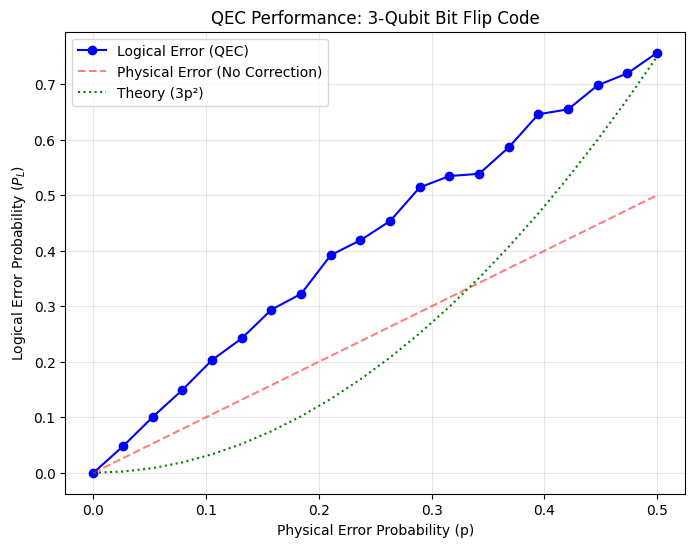

In [ ]:
# Execution
if __name__ == "__main__":
    phys_errs, log_errs = run_qec_simulation()

    # Visualization
    plt.figure(figsize=(8, 6))

    # Plot Logic vs Physical
    plt.plot(phys_errs, log_errs, 'bo-', label='Logical Error (QEC)')

    # Plot "Break-even" line (y=x)
    plt.plot(phys_errs, phys_errs, 'r--', alpha=0.5, label='Physical Error (No Correction)')

    # Theoretical prediction for 3-qubit code: P_L approx 3p^2
    theoretical = 3 * (phys_errs**2)
    plt.plot(phys_errs, theoretical, 'g:', label='Theory (3p²)')

    plt.title("QEC Performance: 3-Qubit Bit Flip Code")
    plt.xlabel("Physical Error Probability (p)")
    plt.ylabel("Logical Error Probability ($P_L$)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Highlight the region where QEC works
    plt.fill_between(phys_errs, 0, phys_errs, where=(np.array(log_errs) < phys_errs),
                     color='green', alpha=0.1, interpolate=True)

    plt.show()